<a href="https://colab.research.google.com/github/chaimaeouardani/img_classification/blob/main1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# GLOBAL VARIABLES
GIT_URL = "https://github.com/chaimaeouardani/img_classification"
IMG_BASE = "img_classification/"
CLASSES = ["hiver", "printemps", "ete", "automne"]


In [18]:
!git clone $GIT_URL
!git -C img_classification pull 

fatal: destination path 'img_classification' already exists and is not an empty directory.
Already up to date.


# Chargement des données :

In [19]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

def load_data(data_path, classes, dataset, image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    print(f"Found {num_images}.")

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        print(f"Processing class \"{classes[idx_class]}\":")
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            print(f"\r\033[K- Processing image {idx_img+1}/{len(dirs)}", end = "")
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

        print(f"\r\033[KFinished processing {classes[idx_class]}")

    return x, y

In [20]:
labels = CLASSES

print("--------loading train data-------")
x_train, y_train = load_data(IMG_BASE, labels, dataset='train', image_size=64)
print(x_train.shape, y_train.shape)
print("--------loading validation data-------")
x_val, y_val = load_data(IMG_BASE, labels, dataset='validation', image_size=64)
print(x_val.shape, y_val.shape)
print("--------loading test data-------")
x_test, y_test = load_data(IMG_BASE, labels, dataset='test', image_size=64)
print(x_test.shape, y_test.shape)

--------loading train data-------
Found 4703.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(4703, 64, 64, 3) (4703, 1)
--------loading validation data-------
Found 1996.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1996, 64, 64, 3) (1996, 1)
--------loading test data-------
Found 1836.
Processing class "hiver":
Finished processing hiver
Processing class "printemps":
Finished processing printemps
Processing class "ete":
Finished processing ete
Processing class "automne":
Finished processing automne
(1836, 64, 64, 3) (1836, 1)


# Visualisation des images de la base de donnee d'entrainement.

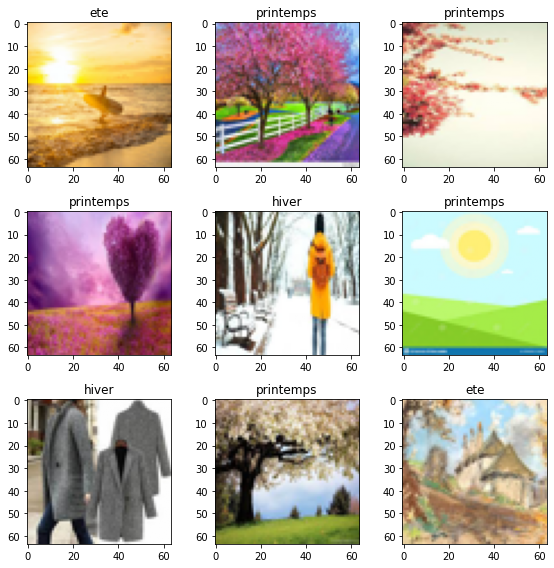

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
shuffle_indices = np.random.permutation(y_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

Normalisation des entrées via une division par 255 des valeurs de pixel.


In [33]:
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255




## Réseau convolutif de base et entrainement des données 

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn import datasets

from tensorflow.keras.layers import Conv2D, MaxPooling2D , Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers , Input , losses

In [99]:
def create_model():
  
  model = Sequential()
  #model.add(Input(shape=(64, 64, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, kernel_size= (3,3), activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(96, kernel_size= (3,3), activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Conv2D(128, kernel_size= (3,3),  activation = 'relu'))
  model.add(MaxPooling2D(2,2))

  model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  model.add(Dense(4, activation='softmax'))

  model.build()


  model.summary()

  return model 

In [100]:
model = create_model()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 6, 6, 96)       

In [101]:
# compile model
opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
147/147 [==============================] - 2s 11ms/step - loss: 1.8383 - accuracy: 0.5433 - val_loss: 0.8287 - val_accuracy: 0.6819
Epoch 2/10
147/147 [==============================] - 1s 8ms/step - loss: 0.8191 - accuracy: 0.6796 - val_loss: 0.6974 - val_accuracy: 0.7305
Epoch 3/10
147/147 [==============================] - 1s 8ms/step - loss: 0.6779 - accuracy: 0.7366 - val_loss: 0.5117 - val_accuracy: 0.8126
Epoch 4/10
147/147 [==============================] - 1s 9ms/step - loss: 0.5803 - accuracy: 0.7814 - val_loss: 0.5099 - val_accuracy: 0.7931
Epoch 5/10
147/147 [==============================] - 1s 9ms/step - loss: 0.5045 - accuracy: 0.8125 - val_loss: 0.3687 - val_accuracy: 0.8642
Epoch 6/10
147/147 [==============================] - 1s 9ms/step - loss: 0.4081 - accuracy: 0.8501 - val_loss: 0.3618 - val_accuracy: 0.8692
Epoch 7/10
147/147 [==============================] - 1s 9ms/step - loss: 0.3415 - accuracy: 0.8754 - val_loss: 0.3072 - val_accuracy: 0.8878
Epoch

# Affichage de l'ananlyse de l'entrainement

In [86]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

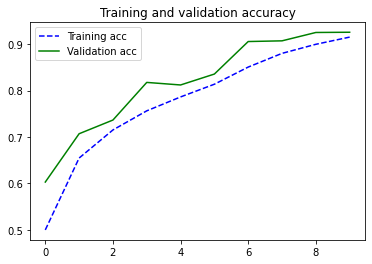

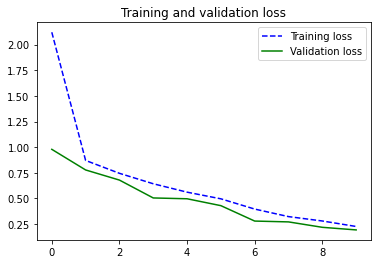

In [87]:

plot_training_analysis(history)


Evaluation pour les données de test :

In [88]:
model.evaluate(x_test,y_test)

58/58 [==============================] - 0s 5ms/step - loss: 0.2117 - accuracy: 0.9232


[0.21172501146793365, 0.923202633857727]

In [116]:
#enregistrer le modèle 2
model.save('weather_model.h5')

## Augmentation de la base de données : 

On utilise deux types d'augmentation : des transformations spatiales (ShiftScaleRotate), et des transformations colorimétriques. 

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.0]
    )


Visualisation des images passées à travers notre boucle d'augmentation de données.

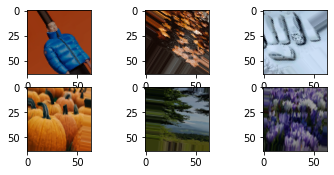

In [90]:

# prepare iterator
it = datagen.flow(x_train, batch_size=5)
# generate samples and plot
for i in range(6):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

Nous allons recréer un autre modèle et relancer l'entraînement.

In [93]:
model = create_model()
opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 6, 6, 96)       

In [104]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=30,
                    )


Epoch 1/30
  7/471 [..............................] - ETA: 9s - loss: 0.6225 - accuracy: 0.8571

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


471/471 [==============================] - 9s 19ms/step - loss: 0.7224 - accuracy: 0.7308 - val_loss: 0.5826 - val_accuracy: 0.7836
Epoch 2/30
471/471 [==============================] - 9s 19ms/step - loss: 0.6987 - accuracy: 0.7423 - val_loss: 0.7789 - val_accuracy: 0.7310
Epoch 3/30
471/471 [==============================] - 9s 20ms/step - loss: 0.6892 - accuracy: 0.7474 - val_loss: 0.6044 - val_accuracy: 0.7946
Epoch 4/30
471/471 [==============================] - 9s 19ms/step - loss: 0.6730 - accuracy: 0.7610 - val_loss: 0.5734 - val_accuracy: 0.8016
Epoch 5/30
471/471 [==============================] - 9s 20ms/step - loss: 0.6520 - accuracy: 0.7629 - val_loss: 0.6119 - val_accuracy: 0.7876
Epoch 6/30
471/471 [==============================] - 9s 19ms/step - loss: 0.6466 - accuracy: 0.7646 - val_loss: 0.5439 - val_accuracy: 0.8136
Epoch 7/30
471/471 [==============================] - 9s 19ms/step - loss: 0.6351 - accuracy: 0.7636 - val_loss: 0.5763 - val_accuracy: 0.8051
Epoch 8/30

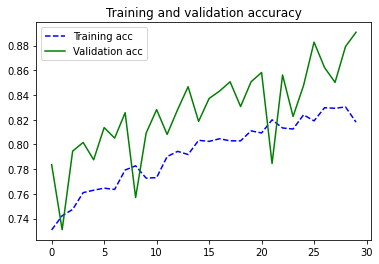

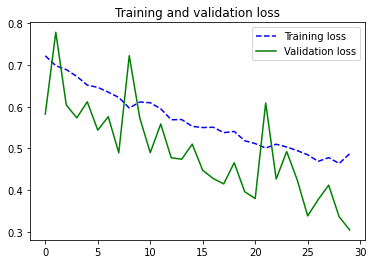

In [105]:
plot_training_analysis(history)

In [106]:
#enregistrer le modèle 2
model.save('weather_model2.h5')

# Transfer Learning

In [117]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(64, 64, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [119]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [121]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

In [124]:
model = Sequential()

model.add(Input(shape=(2*2*512)))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()


model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


history = model.fit(train_features, y_train,
                    epochs=5,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               524544    
                                                                 
 dense_41 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 525,572
Trainable params: 525,572
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


294/294 [==============================] - 2s 4ms/step - loss: 4.1645 - accuracy: 0.6881 - val_loss: 0.7396 - val_accuracy: 0.8838
Epoch 2/5
294/294 [==============================] - 1s 4ms/step - loss: 0.6653 - accuracy: 0.8873 - val_loss: 0.2033 - val_accuracy: 0.9544
Epoch 3/5
294/294 [==============================] - 1s 4ms/step - loss: 0.1396 - accuracy: 0.9617 - val_loss: 0.0513 - val_accuracy: 0.9890
Epoch 4/5
294/294 [==============================] - 1s 3ms/step - loss: 0.0323 - accuracy: 0.9892 - val_loss: 0.0269 - val_accuracy: 0.9975
Epoch 5/5
294/294 [==============================] - 1s 3ms/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 0.0308 - val_accuracy: 0.9975


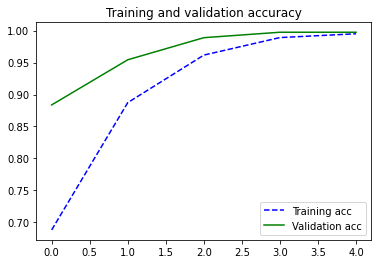

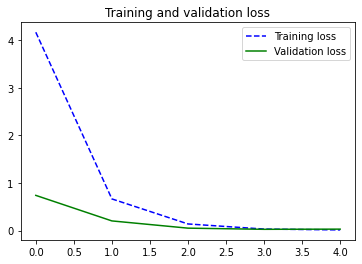

In [126]:
plot_training_analysis(history)

On a du surapprentissage acc = 99.5% donc on cherche a **intégrer** de l'augmentation de données texte en gras

In [129]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))
conv_base.trainable = False
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_19 (Flatten)        (None, 2048)              0         
                                                                 
 dense_44 (Dense)            (None, 256)               524544    
                                                                 
 dense_45 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 15,240,260
Trainable params: 525,572
Non-trainable params: 14,714,688
_________________________________________________________________


In [151]:
opt = optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy' , metrics = ['accuracy'])



In [152]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=10,
                    )



Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


471/471 [==============================] - 11s 23ms/step - loss: 0.6205 - accuracy: 0.2401 - val_loss: 0.5427 - val_accuracy: 0.2535
Epoch 2/10
471/471 [==============================] - 10s 22ms/step - loss: 0.5577 - accuracy: 0.2369 - val_loss: 0.4801 - val_accuracy: 0.2605
Epoch 3/10
471/471 [==============================] - 11s 22ms/step - loss: 0.5018 - accuracy: 0.2371 - val_loss: 0.4734 - val_accuracy: 0.2475
Epoch 4/10
166/471 [=========>....................] - ETA: 6s - loss: 0.4781 - accuracy: 0.2422

KeyboardInterrupt: ignored

cp: cannot stat 'projet_DL.ipynb': No such file or directory


## Tester pour des entrées non présentes dans les données d'entrainement:

In [113]:
def load_image(path):
  img = Image.open(path)
  img = img.convert('RGB')
  img = img.resize((64,64))
  return np.asarray(img)

In [114]:
from keras.models import load_model

img = load_image('img_classification/test.jpg')
m = load_model('weather_model2.h5')
result = m.predict(img)


ValueError: ignored